### As always, import the necessary packages

In [5]:
#-----Utils-----
from extrapackages.siamese_network import build_siamese_model
from extrapackages import utils
#-----Tensorflow-----
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Dense, Input
from tensorflow.keras.datasets import mnist
#-----Others-------
import numpy as np
import os

### Configuration options

In [11]:
# specify the shape of the inputs for our network
IMG_SHAPE = (28, 28, 1)

# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 10

# define the path to the base output directory
BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

### Get the data and preprocess

In [6]:
(trainX, trainY), (testX, testY) = mnist.load_data()

#Scaling the images
trainX = trainX / 255.0
testX = testX / 255.0

#Add extra channel. This is due to the make_pairs function (check utils.py for more details)
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

### Get the pairs

In [7]:
(pairTrain, labelTrain) = utils.make_pairs(trainX, trainY)
(pairTest, labelTest) = utils.make_pairs(testX, testY)

### Configure the Siamese network and the inputs/outputs

In [8]:
#Define the inputs (image A and B) of the Siamese network
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

#We initialize the network but we take it as a feature extractor. This is to obey one of the principles pf Siamese Networks: same weights updates
#If we give first imgA as input and then imgB then the weights will be different
feature_extractor = build_siamese_model(IMG_SHAPE)
featsA = feature_extractor(imgA)
featsB = feature_extractor(imgB)

2022-09-14 00:36:54.924311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 00:36:54.968205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 00:36:54.968485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 00:36:54.969420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
#Once we have the features, we pass those through the euclidian distance (to calculate similarity) and then into the Dense Layer to get the output
#This is using the functional API
distance = Lambda(utils.euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation= "sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

### Compile the model and train it

In [10]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
#Give the positive images (1) and negatives(0) into a nested list
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10


2022-09-14 00:48:40.136171: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-14 00:48:41.260564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-14 00:48:41.261637: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-14 00:48:41.261689: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-14 00:48:41.262502: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-14 00:48:41.262625: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1875/1875 [==============================] - 22s 10ms/step - loss: 0.6267 - accuracy: 0.6375 - val_loss: 0.5805 - val_accuracy: 0.6995
Epoch 2/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.5691 - accuracy: 0.7071 - val_loss: 0.5076 - val_accuracy: 0.7675
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5272 - accuracy: 0.7399 - val_loss: 0.4652 - val_accuracy: 0.7925
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.5010 - accuracy: 0.7572 - val_loss: 0.4415 - val_accuracy: 0.8023
Epoch 5/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4826 - accuracy: 0.7698 - val_loss: 0.4245 - val_accuracy: 0.8086
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4705 - accuracy: 0.7764 - val_loss: 0.4083 - val_accuracy: 0.8174
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4589 - accuracy: 0.7827 - val_loss: 0.4015 - val_accura

In [13]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: output/siamese_model/assets


INFO:tensorflow:Assets written to: output/siamese_model/assets


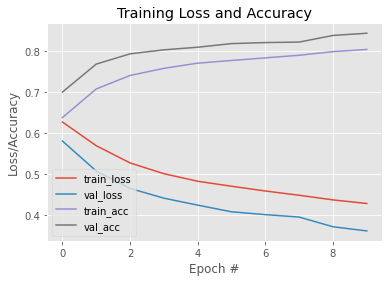

In [15]:
utils.plot_training(history, PLOT_PATH)